In [25]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import folium

# 1. Load Data
df = pd.read_csv('Miami_Accidents_Cleaned.csv')

In [26]:
df.head()

,ID,Severity,Start_Time,Start_Lat,Start_Lng,Description,Street,City,Weather_Condition
0,A-116064,2,2016-11-30 16:40:31,25.627699,-80.374451,Accident on FL-992 152nd St at Lincoln Blvd.,SW 152nd St,Miami,Mostly Cloudy
1,A-116067,2,2016-11-30 15:16:19,25.963093,-80.185677,Left turn lane blocked due to accident on FL-8...,San Simeon Way,Miami,Scattered Clouds
2,A-116068,2,2016-11-30 16:55:31,25.841373,-80.322037,Queueing traffic due to accident on FL-826 Pal...,Palmetto Expy N,Miami,Mostly Cloudy
3,A-116069,3,2016-11-30 16:57:23,25.812199,-80.205856,Accident on I-95 Southbound at Exits 4 4B FL-1...,I-95 N,Miami,Mostly Cloudy
4,A-116071,2,2016-11-30 17:15:52,25.781235,-80.337181,Queueing traffic due to accident on FL-836 Dol...,Dolphin Expy E,Miami,Mostly Cloudy


In [27]:
df.isnull().sum()

ID                      0
Severity                0
Start_Time              0
Start_Lat               0
Start_Lng               0
Description             0
Street                201
City                    0
Weather_Condition    1585
dtype: int64

In [28]:
df['City'].value_counts()


City
Miami    186917
Name: count, dtype: int64

In [29]:
df.shape

(186917, 9)

In [30]:
# 2.2 Drop exact duplicates (all columns) and near-duplicates (same lat/lng and time)
df = df.drop_duplicates()
print("After drop_duplicates:", df.shape)

After drop_duplicates: (186917, 9)


In [31]:
# If there are duplicate GPS and Start_Time entries, remove duplicates by subset
if 'Start_Time' in df.columns:
    df = df.drop_duplicates(subset=['Start_Lat', 'Start_Lng', 'Start_Time'])
else:
    df = df.drop_duplicates(subset=['Start_Lat', 'Start_Lng'])

print("After geo-time dedup:", df.shape)

After geo-time dedup: (159805, 9)


In [32]:
# 2.3 Ensure coordinate columns exist and are numeric
df['Start_Lat'] = pd.to_numeric(df['Start_Lat'], errors='coerce')
df['Start_Lng'] = pd.to_numeric(df['Start_Lng'], errors='coerce')

In [33]:
# 2.4 Drop rows missing coordinates (required)
df = df.dropna(subset=['Start_Lat', 'Start_Lng']).reset_index(drop=True)
print("After dropping missing coords:", df.shape)

After dropping missing coords: (159805, 9)


In [34]:
# 2.5 Fix Start_Time type
if 'Start_Time' in df.columns:
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')


In [35]:
# 2.6 Fill optional fields
if 'Weather_Condition' in df.columns:
    df['Weather_Condition'] = df['Weather_Condition'].fillna('Unknown')
if 'Street' in df.columns:
    df['Street'] = df['Street'].fillna('Not Available')

In [36]:
df.isnull().sum()

ID                       0
Severity                 0
Start_Time           27742
Start_Lat                0
Start_Lng                0
Description              0
Street                   0
City                     0
Weather_Condition        0
dtype: int64

In [37]:
df = df.dropna(subset=['Start_Time'])


In [38]:
df.isnull().sum()

ID                   0
Severity             0
Start_Time           0
Start_Lat            0
Start_Lng            0
Description          0
Street               0
City                 0
Weather_Condition    0
dtype: int64

In [39]:
# ---- 4.0 Create hour feature (required) ----
if 'Start_Time' in df.columns:
    df['hour'] = df['Start_Time'].dt.hour

# ---- 4.1 Time features ----
if 'Start_Time' in df.columns:
    df['date'] = df['Start_Time'].dt.date
    df['weekday'] = df['Start_Time'].dt.weekday      # Monday = 0
    df['is_weekend'] = df['weekday'].isin([5, 6])    # Sat, Sun

# ---- 4.2 Severity flag ----
if 'Severity' in df.columns:
    df['sev_major'] = (df['Severity'] >= 3).astype(int)

# ---- 4.3 Preview ----
df[['Start_Lat','Start_Lng','hour','weekday','is_weekend','sev_major']].head()


,Start_Lat,Start_Lng,hour,weekday,is_weekend,sev_major
0,25.627699,-80.374451,16,2,False,0
1,25.963093,-80.185677,15,2,False,0
2,25.841373,-80.322037,16,2,False,0
3,25.812199,-80.205856,16,2,False,1
4,25.781235,-80.337181,17,2,False,0


heatmap using folium


In [40]:
import folium
from folium.plugins import HeatMap

# Center of Miami
m = folium.Map(location=[25.7617, -80.1918], zoom_start=11)

# Heatmap data
heat_data = df[['Start_Lat', 'Start_Lng']].values.tolist()

HeatMap(heat_data, radius=8, blur=10).add_to(m)

# Save the map
m.save("miami_accident_heatmap.html")

print("✅ Heatmap created! Open 'miami_accident_heatmap.html' to view it.")






✅ Heatmap created! Open 'miami_accident_heatmap.html' to view it.


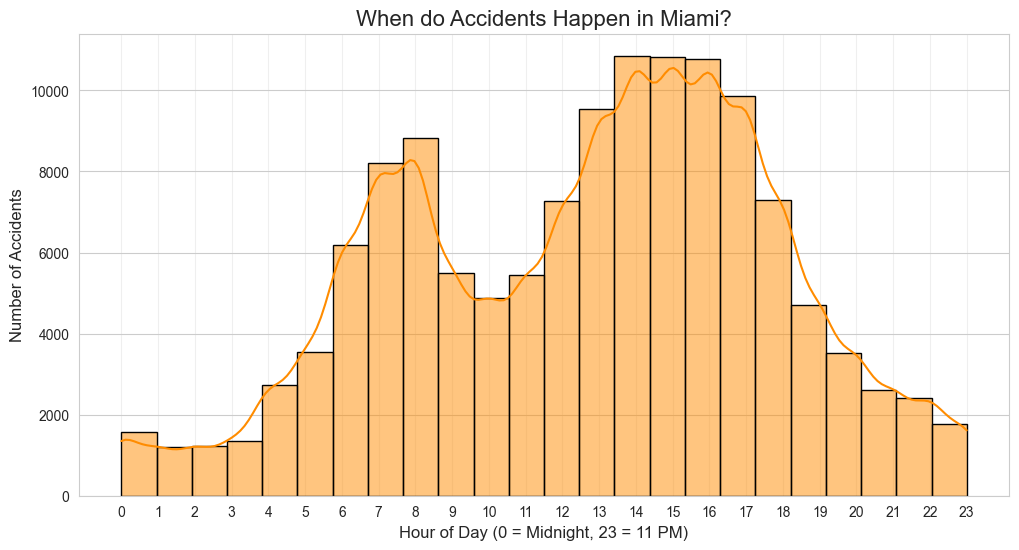

🕒 Peak Accident Hours:
hour
14    10859
15    10817
16    10774
Name: count, dtype: int64


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set graph style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Plot the distribution of accidents by Hour
# We use the 'hour' feature created in Step 4
sns.histplot(df['hour'], bins=24, kde=True, color='darkorange', edgecolor='black')

plt.title('When do Accidents Happen in Miami?', fontsize=16)
plt.xlabel('Hour of Day (0 = Midnight, 23 = 11 PM)', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.xticks(range(0, 24)) # Show every hour number
plt.grid(axis='x', alpha=0.3)
plt.show()

# Print the exact top 3 peak hours
print("🕒 Peak Accident Hours:")
print(df['hour'].value_counts().head(3))

ELBOW METHOD 

⏳ Calculating distance to the 15-th nearest neighbor...


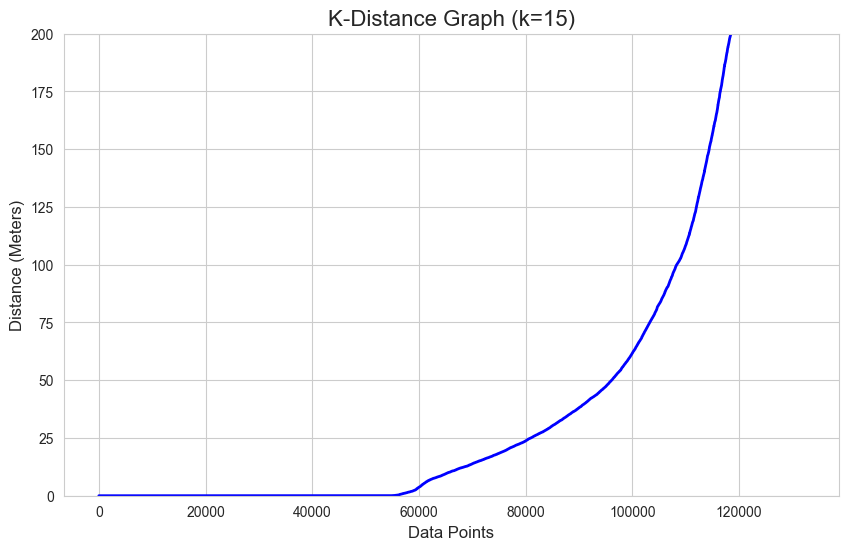

In [42]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 1. Prepare Data (Convert Lat/Lng to Radians)
# DBSCAN using Haversine metric REQUIRES radians
coords = df[['Start_Lat', 'Start_Lng']].to_numpy()
coords_radians = np.radians(coords)

# 2. Define K (Min_Samples)
# We stick to 15 (Standard for traffic data to avoid noise)
k = 15

print(f"⏳ Calculating distance to the {k}-th nearest neighbor...")

# 3. Run Nearest Neighbors
# Note: We use 'haversine' metric here to match DBSCAN later
nbrs = NearestNeighbors(n_neighbors=k, metric='haversine', algorithm='ball_tree').fit(coords_radians)
distances, indices = nbrs.kneighbors(coords_radians)

# 4. Process Distances for Plotting
# Take the distance to the k-th neighbor (last column)
k_distances = distances[:, k-1]
k_distances = np.sort(k_distances)

# CRITICAL: Convert Radians to Meters for the graph to make sense
# Earth Radius = 6,371,008.8 meters
k_distances_meters = k_distances * 6371008.8


# Plot CLEAN graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances_meters, color='blue', linewidth=2)

plt.title(f'K-Distance Graph (k={k})', fontsize=16)
plt.ylabel('Distance (Meters)', fontsize=12)
plt.xlabel('Data Points', fontsize=12)
plt.grid(True)
plt.ylim(0, 200) # Zoom in to the relevant area
plt.show()

SEVERITY

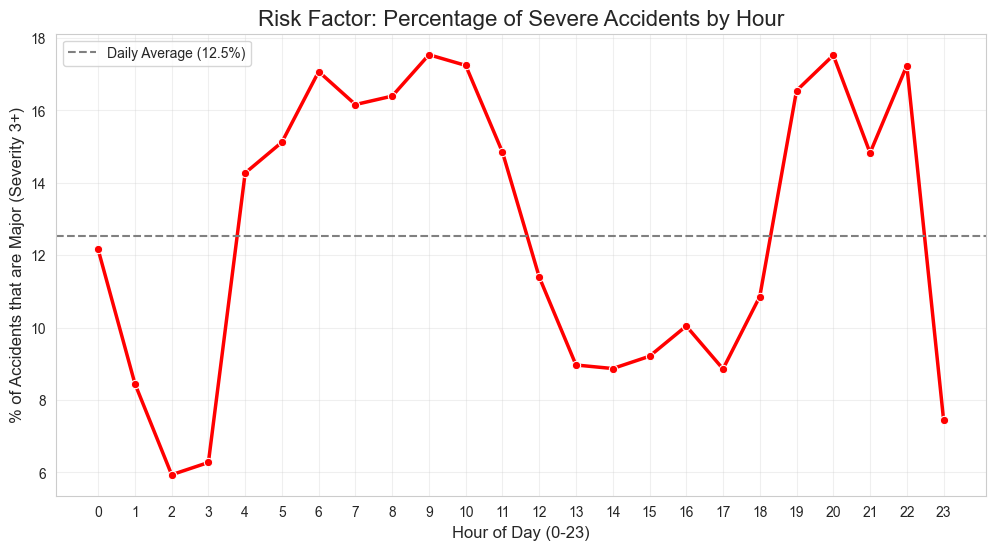

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the % of Severe Accidents per Hour
# We use the 'sev_major' column you created earlier (0 or 1)
# Taking the mean of 0s and 1s gives us the percentage!
severity_by_hour = df.groupby('hour')['sev_major'].mean() * 100

# 2. Plot the Trend
plt.figure(figsize=(12, 6))

# Plot the line
sns.lineplot(x=severity_by_hour.index, y=severity_by_hour.values, marker='o', color='red', linewidth=2.5)

# Add a reference line for the overall average
overall_avg = df['sev_major'].mean() * 100
plt.axhline(overall_avg, color='grey', linestyle='--', label=f'Daily Average ({overall_avg:.1f}%)')

plt.title('Risk Factor: Percentage of Severe Accidents by Hour', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('% of Accidents that are Major (Severity 3+)', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [44]:
from sklearn.cluster import DBSCAN
import numpy as np

# --- 1. PREPARE DATA ---
# We convert to radians again just to be safe and self-contained
coords = df[['Start_Lat', 'Start_Lng']].to_numpy()
coords_radians = np.radians(coords)

# --- 2. SETUP PARAMETERS ---
# Based on your K-Distance Graph Analysis
EPSILON_METERS = 65    # The "Elbow" point you found
MIN_SAMPLES = 15       # The density threshold

# Convert meters to radians for the Haversine metric
KMS_PER_RADIAN = 6371.0088
epsilon_radians = (EPSILON_METERS / 1000) / KMS_PER_RADIAN

print(f"🚀 Training DBSCAN with Radius={EPSILON_METERS}m and Min_Samples={MIN_SAMPLES} ...")

# --- 3. RUN ALGORITHM ---
# We use 'ball_tree' because it's fast for lat/lon data
db = DBSCAN(
    eps=epsilon_radians, 
    min_samples=MIN_SAMPLES, 
    algorithm='ball_tree', 
    metric='haversine'
).fit(coords_radians)

# --- 4. SAVE RESULTS ---
df['cluster'] = db.labels_

# --- 5. EVALUATE ---
# Count clusters (excluding noise -1)
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = list(db.labels_).count(-1)
noise_ratio = n_noise / len(df)

print(f"\n✅ RESULTS:")
print(f"   - Clusters Found: {n_clusters}")
print(f"   - Noise Ratio: {noise_ratio:.2%} (Target: ~10-20%)")

🚀 Training DBSCAN with Radius=65m and Min_Samples=15 ...

✅ RESULTS:
   - Clusters Found: 984
   - Noise Ratio: 20.14% (Target: ~10-20%)


In [45]:
import pandas as pd

# 1. ENSURE SEVERITY FLAG EXISTS
if 'sev_major' not in df.columns:
    df['sev_major'] = df['Severity'].apply(lambda x: 1 if x >= 3 else 0)

# 2. FILTER NOISE
hotspots = df[df['cluster'] != -1].copy()

# 3. CALCULATE INTELLIGENCE REPORT
# We group by the new specific clusters
leaderboard = hotspots.groupby('cluster').agg({
    'Start_Lat': 'mean',    # Exact center of the intersection
    'Start_Lng': 'mean',
    'ID': 'count',          # Total Accidents
    'sev_major': 'sum',     # Major Accidents
    # Extract top street name
    'Street': lambda x: x.mode()[0] if not x.mode().empty else "Unknown"
}).reset_index()

# Rename columns
leaderboard.columns = ['Cluster_ID', 'Latitude', 'Longitude', 'Total_Accidents', 'Major_Accidents', 'Primary_Street']

# 4. RANK BY SEVERITY (The "Kill Zones")
leaderboard = leaderboard.sort_values(by='Major_Accidents', ascending=False)

# 5. DISPLAY TOP 10
print("🏆 TOP 10 MOST DANGEROUS INTERSECTIONS (Ranked by Severity):")
print(leaderboard[['Primary_Street', 'Total_Accidents', 'Major_Accidents']].head(10))

# 6. EXPORT
leaderboard.to_csv("Precision_Hotspot_Report.csv", index=False)
print("\n✅ Saved 'Precision_Hotspot_Report.csv'.")

🏆 TOP 10 MOST DANGEROUS INTERSECTIONS (Ranked by Severity):
   Primary_Street  Total_Accidents  Major_Accidents
14         I-95 S             5070             2300
3          I-95 N             1802             1082
23         I-95 S             1898             1027
50         I-95 N             1963             1018
13         I-95 S             1458              989
48     NW 6th Ave             1490              890
5          I-95 S             1827              810
26         I-95 S             1978              754
24         I-95 N             1245              713
34     NW 62nd St             1097              571

✅ Saved 'Precision_Hotspot_Report.csv'.
